# initialization

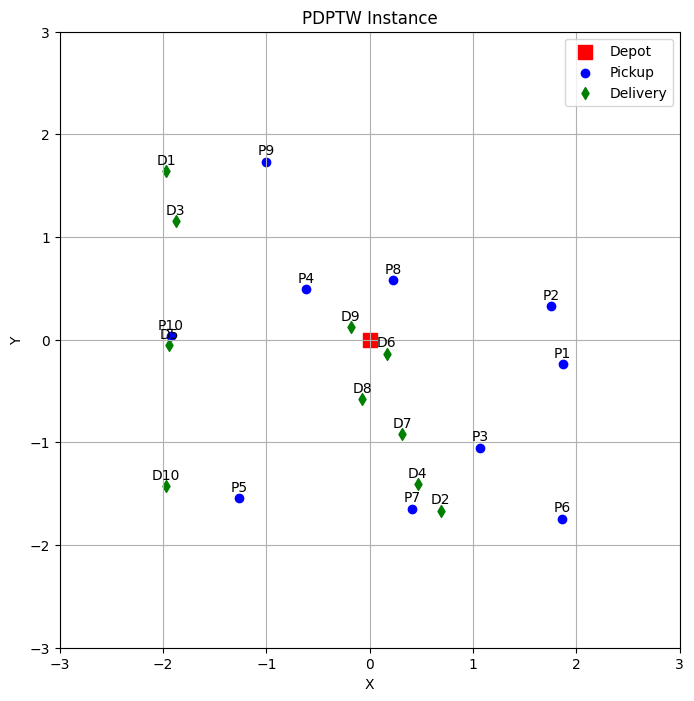

In [11]:
import random
from instance import PDPTWInstance
from solution import PDPTWSolution
from solver import greedy_insertion_init
from operators import RemovalOperators, RepairOperators, SwapOperators

# 参数设置
n = 10  # pickup点的数量
map_size = 2  # 地图大小
speed = 4  # 车辆速度
extra_time = 10  # delivery点时间窗口起始时间的额外时间
num_vehicles = 5  # 车辆数量
vehicle_capacity = 5  # 车辆容量
battery_capacity = 240  # 电池容量
battery_consume_rate = 1  # 电池消耗率

instance = PDPTWInstance(n, map_size, speed, extra_time, seed=1234)
instance.plot_instance()
df = instance.to_dataframe()

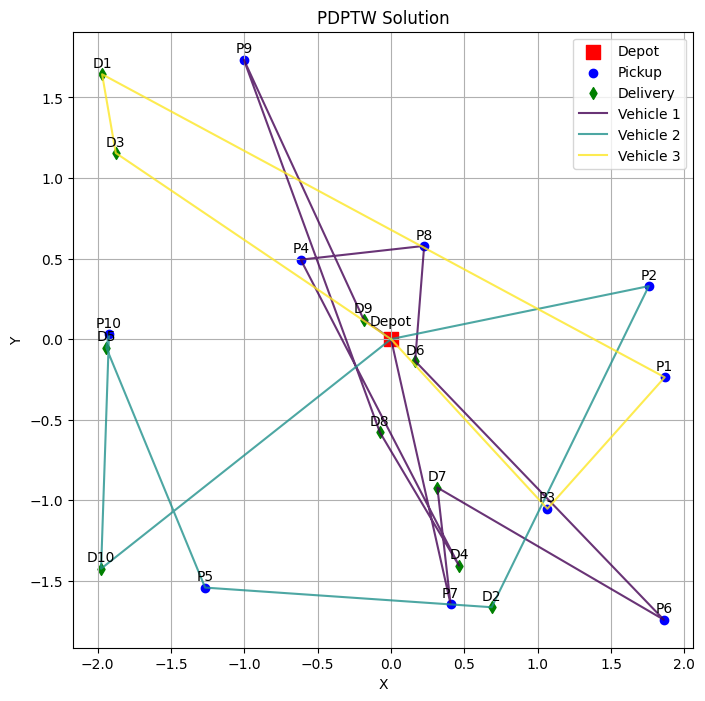

[[0, 7, 17, 6, 16, 8, 4, 14, 18, 9, 19, 0],
 [0, 2, 12, 5, 15, 10, 20, 0],
 [0, 3, 1, 11, 13, 0],
 [0, 0],
 [0, 0]]

In [12]:
initial_solution = greedy_insertion_init(instance, num_vehicles, vehicle_capacity, battery_capacity, battery_consume_rate)
initial_solution.plot_solution()
initial_solution.routes

# Removal

In [13]:
removal_operators = RemovalOperators(initial_solution)
new_solution, removed_requests = removal_operators.random_removal(3)
new_solution.routes

TypeError: 'PDPTWSolution' object is not iterable